<a href="https://colab.research.google.com/github/ffelicioni/kaggle_tps_jan2022/blob/main/kaggle_tps_jan2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install pystan==2.19.1.1

In [35]:
!pip install prophet

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.linear_model import LinearRegression

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

In [37]:
import prophet
print('Prophet %s' % prophet.__version__)

Prophet 1.0


In [38]:
#from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [39]:
!pip install statsmodels
#!pip install statsmodels.tsa.deterministic #requirement python>3.9

In [40]:
train_path = 'https://raw.githubusercontent.com/ccollado7/kaggle-tps-jan2022/main/data/raw/train.csv'
test_path = 'https://raw.githubusercontent.com/ccollado7/kaggle-tps-jan2022/main/data/raw/test.csv'

In [41]:
train = pd.read_csv(train_path)
train['date'] = pd.to_datetime(train['date'])
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['week'] = train['date'].dt.week
train['day_month'] = train['date'].dt.day
train['day_year'] = train['date'].dt.dayofyear 
countrys = train['country'].unique()
stores = train['store'].unique()
products = train['product'].unique()

In [42]:
train.head()

,row_id,date,country,store,product,num_sold,year,month,week,day_month,day_year
0,0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329,2015,1,1,1,1
1,1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520,2015,1,1,1,1
2,2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146,2015,1,1,1,1
3,3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572,2015,1,1,1,1
4,4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911,2015,1,1,1,1


In [43]:
test = pd.read_csv(test_path)
test = pd.read_csv(test_path)
test['date'] = pd.to_datetime(test['date'])
test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['week'] = test['date'].dt.week
test['day_month'] = test['date'].dt.day
test['day_year'] = test['date'].dt.dayofyear 
#test['num_sold'] = 0
test.head()

,row_id,date,country,store,product,year,month,week,day_month,day_year
0,26298,2019-01-01,Finland,KaggleMart,Kaggle Mug,2019,1,1,1,1
1,26299,2019-01-01,Finland,KaggleMart,Kaggle Hat,2019,1,1,1,1
2,26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker,2019,1,1,1,1
3,26301,2019-01-01,Finland,KaggleRama,Kaggle Mug,2019,1,1,1,1
4,26302,2019-01-01,Finland,KaggleRama,Kaggle Hat,2019,1,1,1,1


Functions

In [44]:
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def entrenar_modelo(df, pais, incluir_holidays):
  model=prophet.Prophet()
  # fit the model
  #model.add_seasonality(name='mensual',period=365/12,fourier_order=4)
  if incluir_holidays:
    model.add_country_holidays(country_name=pais)
  
  model.fit(df)
  future = model.make_future_dataframe(periods=365)
  forecast = model.predict(future)
  #model.plot(forecast);
  #print(forecast)
  N=len(forecast)
  y_fore=forecast['yhat']
  y_fore_future=pd.DataFrame(y_fore[-365:])
  y_fore_train=pd.DataFrame(y_fore[0:N-365])
  return y_fore_future['yhat'], y_fore_train['yhat']


def smape_loss(y_true, y_pred):
    """SMAPE Loss"""
    return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200

def entrenar_hibrido(y_resid,X_2_train,X_2_test):
  modelito=XGBRegressor()
  modelito.fit(X_2_train, y_resid)
  y_fit2 = pd.Series(modelito.predict(X_2_test), index=X_2_test.index)
  return np.array(y_fit2)

## Example: Finland+KaggleMart+ Kaggle Mug

Original data
*   Train 2015-2017
*   Test 2018



In [45]:
sub_train = train[(train['country'] == "Finland") & (train['store'] == "KaggleMart") & (train['product'] == "Kaggle Mug")]
sub_train = sub_train.set_index("date")
df=pd.DataFrame(sub_train['num_sold'])
X = df.index  # features
y = df.loc[:, 'num_sold']  # target

y1 = y.copy()  # the target
N=len(y)


X_train, X_val, y_train, y_val = train_test_split(X, y1, shuffle=False,train_size=N-365,test_size=365)
y_val_original=y_val
y_train_original=y_train

Prophet: dataset [ds,y]

In [46]:
df=pd.DataFrame(y_train) 
df=df.reset_index('date') 
df.rename({'date': 'ds','num_sold':'y'}, axis=1, inplace=True)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


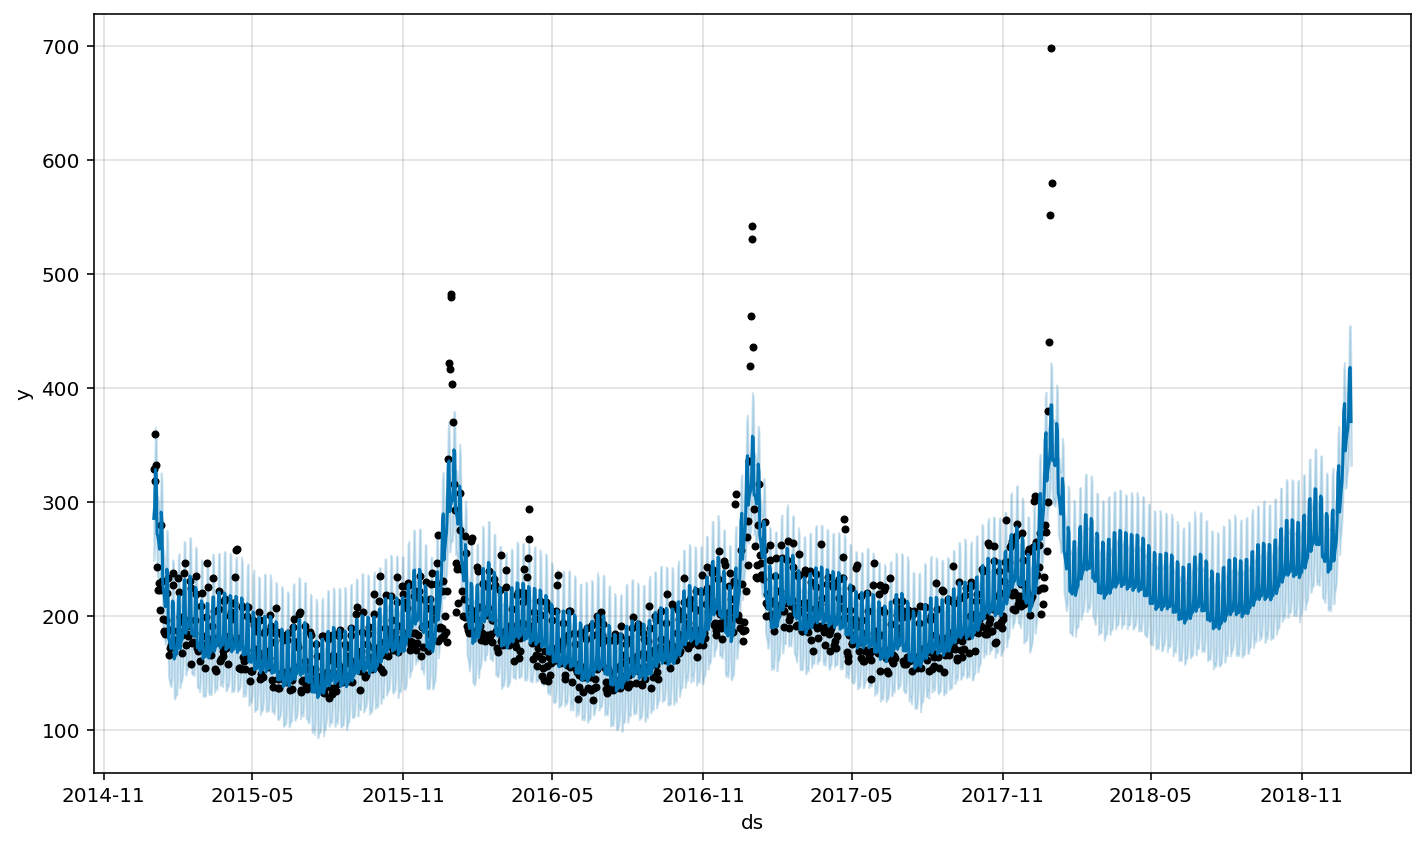

In [47]:
model=prophet.Prophet()
# fit the model
#model.add_seasonality(name='mensual',period=365/12,fourier_order=4)
#model.add_country_holidays(country_name='Finland')
model.fit(df)

future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)
model.plot(forecast);

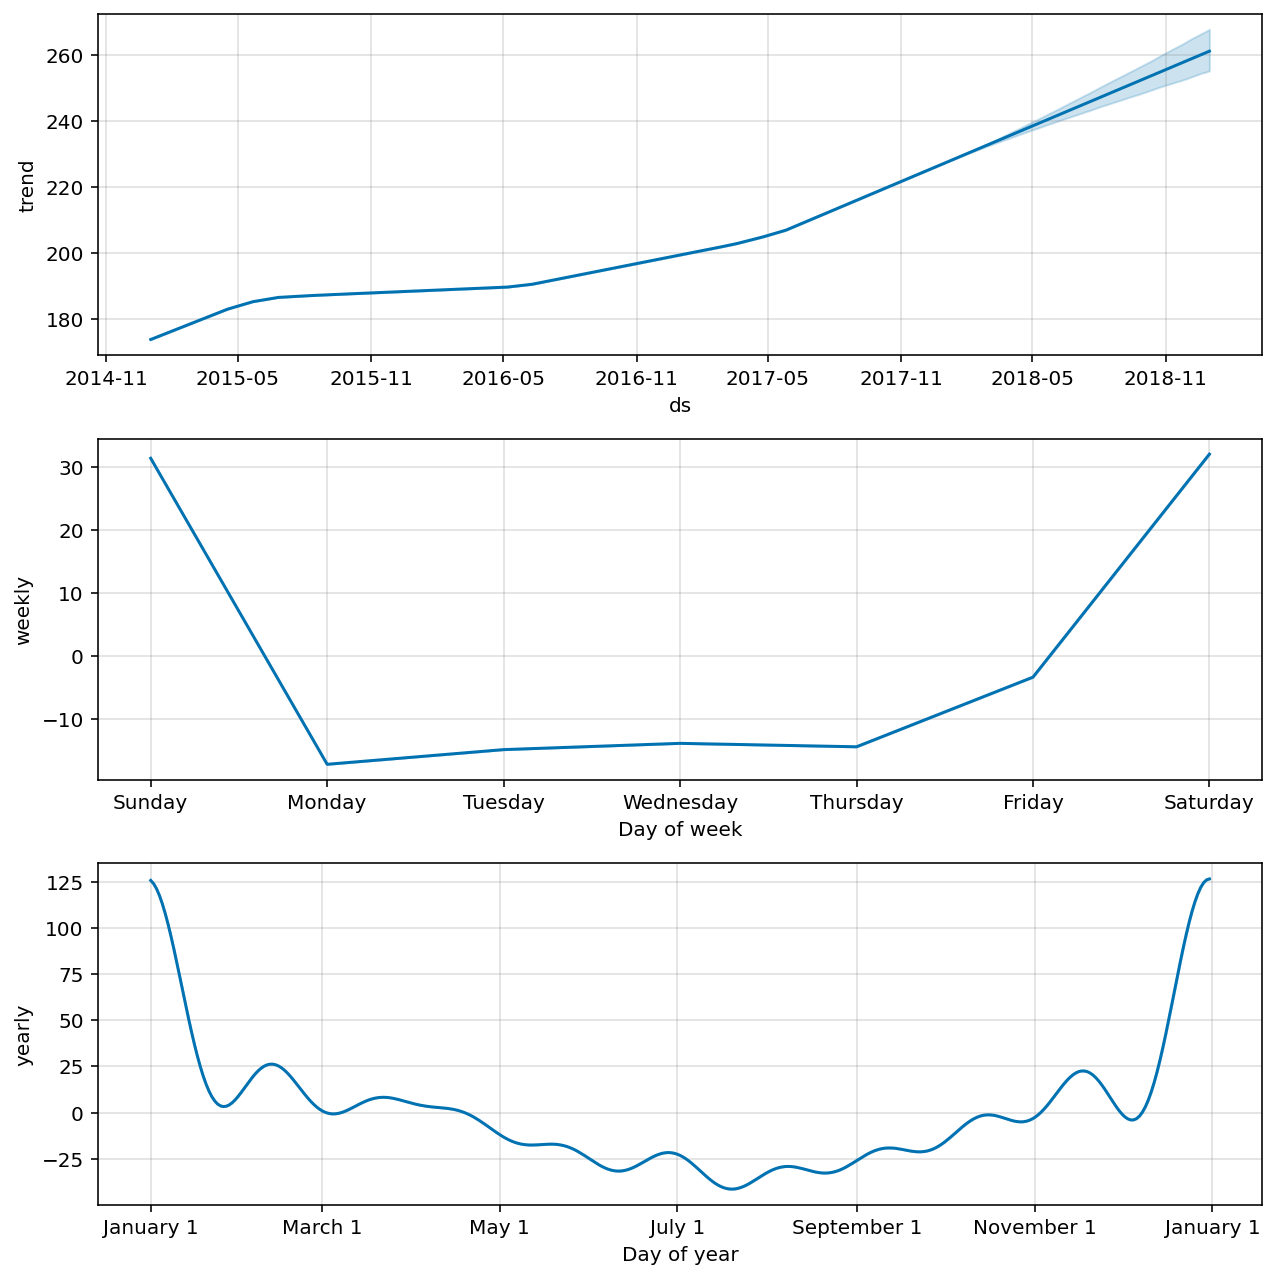

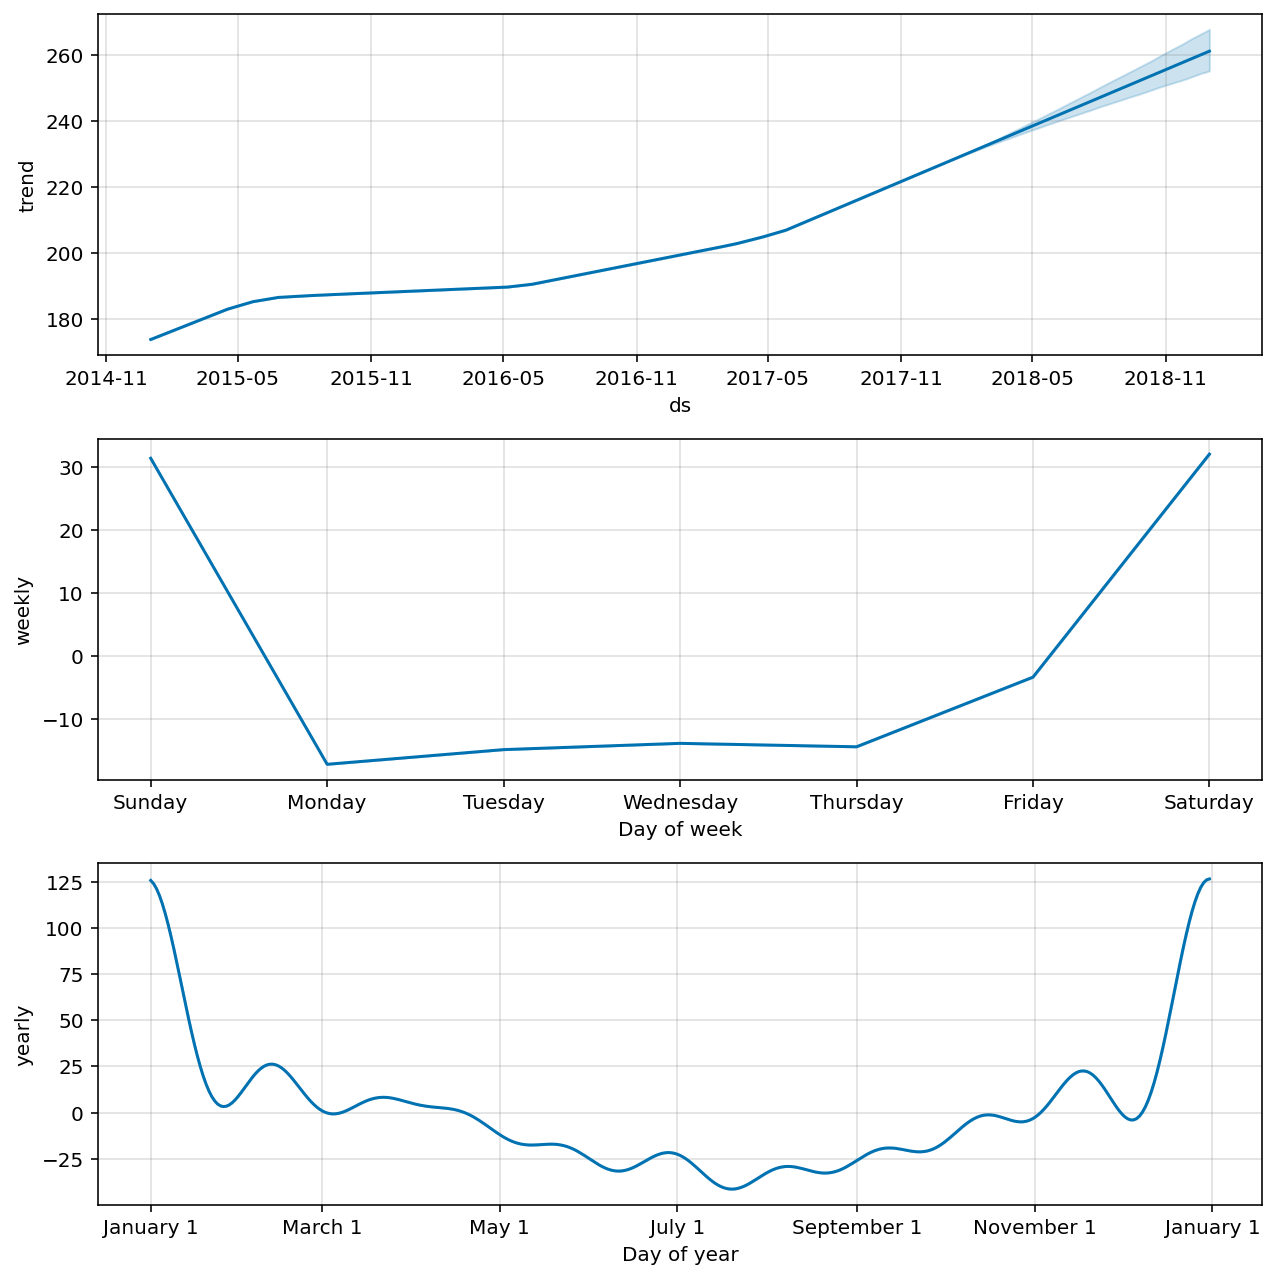

In [48]:
model.plot_components(forecast)

In [49]:
y_forecast_future,_=entrenar_modelo(df,'Finland',True)
smape_loss(np.array(y_val), np.array(y_forecast_future)).mean()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


11.248860256889838

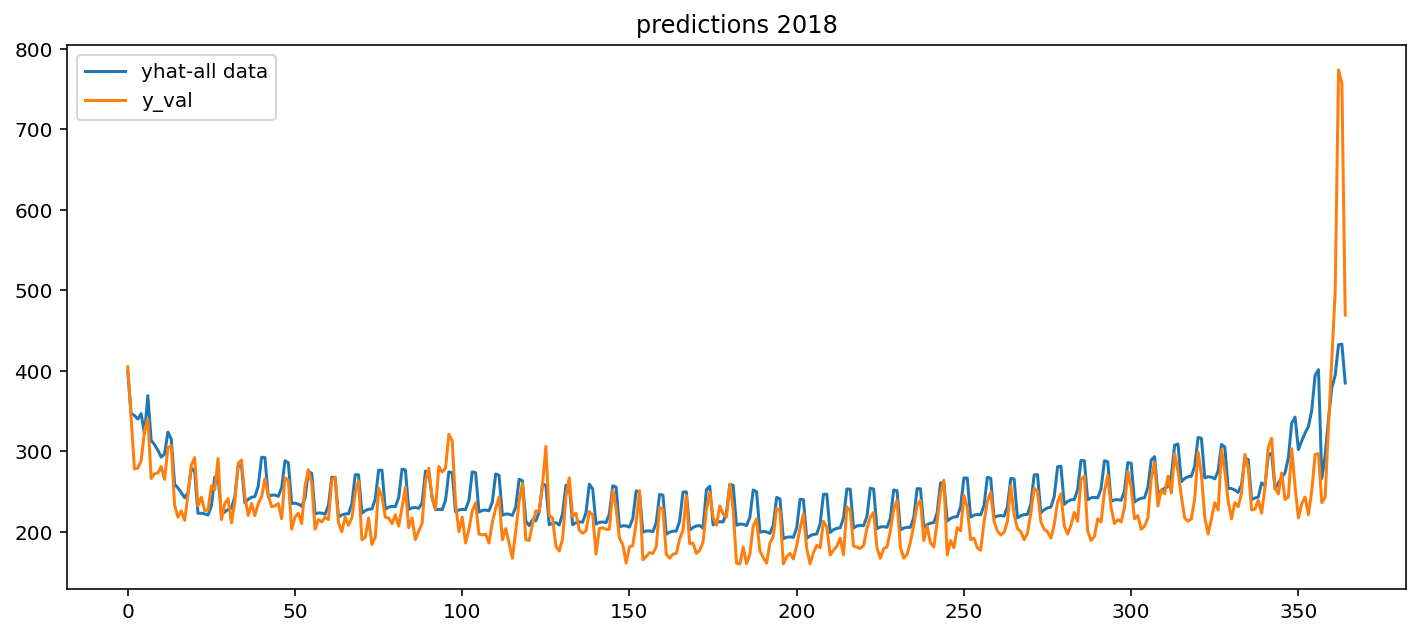

In [50]:
plt.figure(figsize=(12, 5))
ax=plt.plot(np.array(y_forecast_future))
plt.plot(np.array(y_val_original))
plt.title('predictions 2018')
plt.legend(['yhat-all data', 'y_val'])

Removing outliers
*   Train 2015-2017
*   Test 2018

In [51]:
sub_train = train[(train['country'] == "Finland") & (train['store'] == "KaggleMart") & (train['product'] == "Kaggle Mug")]
sub_train = sub_train.set_index("date")
df=pd.DataFrame(sub_train['num_sold'])
X = df.index  # features
y = df.loc[:, 'num_sold']  # target

y1 = y.copy()  # the target
yx=y1.reset_index('date')
yx['num_sold']=[ None if i >= np.percentile(yx['num_sold'], 95) or i <= np.percentile(yx['num_sold'] , 5) else i for i in yx['num_sold']  ]
y1=yx.set_index('date')
N=len(y)

X_train, X_val, y_train, y_val = train_test_split(X, y1, shuffle=False,train_size=N-365,test_size=365)

In [52]:
df=pd.DataFrame(y_train)
df=df.reset_index('date')
df.rename({'date': 'ds','num_sold':'y'}, axis=1, inplace=True)

In [53]:
y_forecast_future,y_forecast_train=entrenar_modelo(df,'Finland',False)
smape_loss(np.array(y_val_original), np.array(y_forecast_future)).mean()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


7.0997038670304295

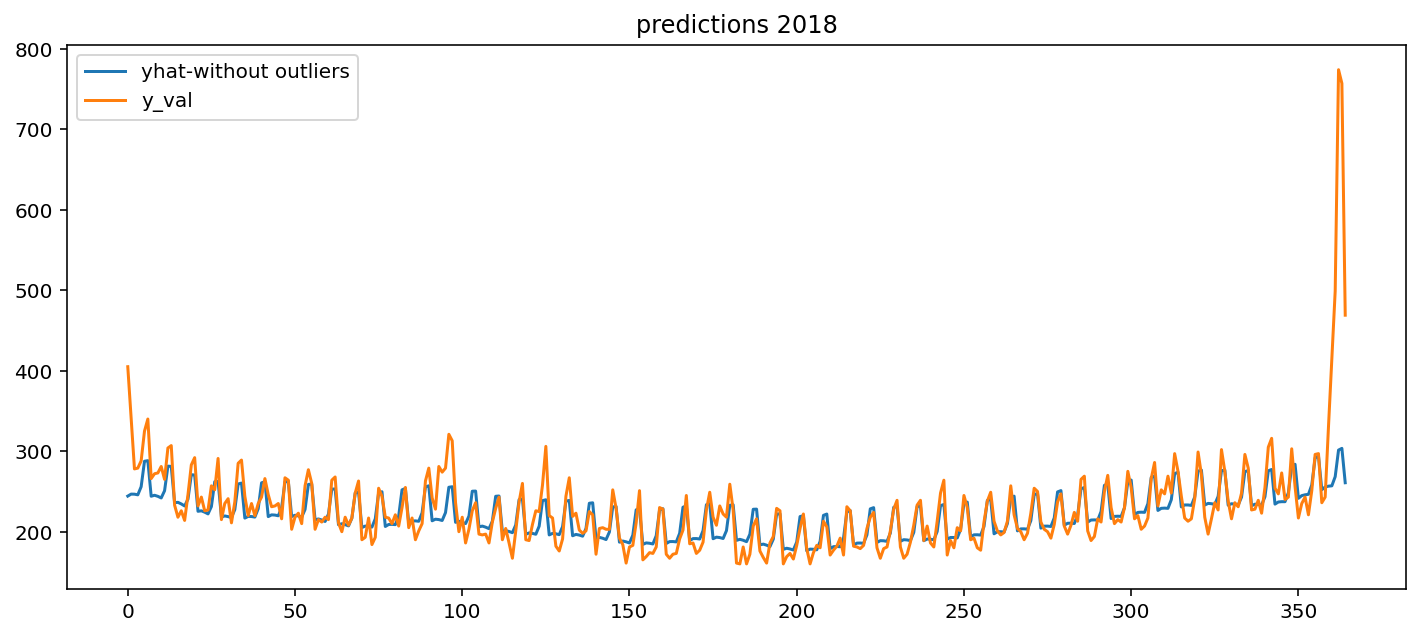

In [54]:
plt.figure(figsize=(12, 5))
ax=plt.plot(np.array(y_forecast_future))
plt.plot(np.array(y_val_original))
plt.title('predictions 2018')
plt.legend(['yhat-without outliers', 'y_val'])

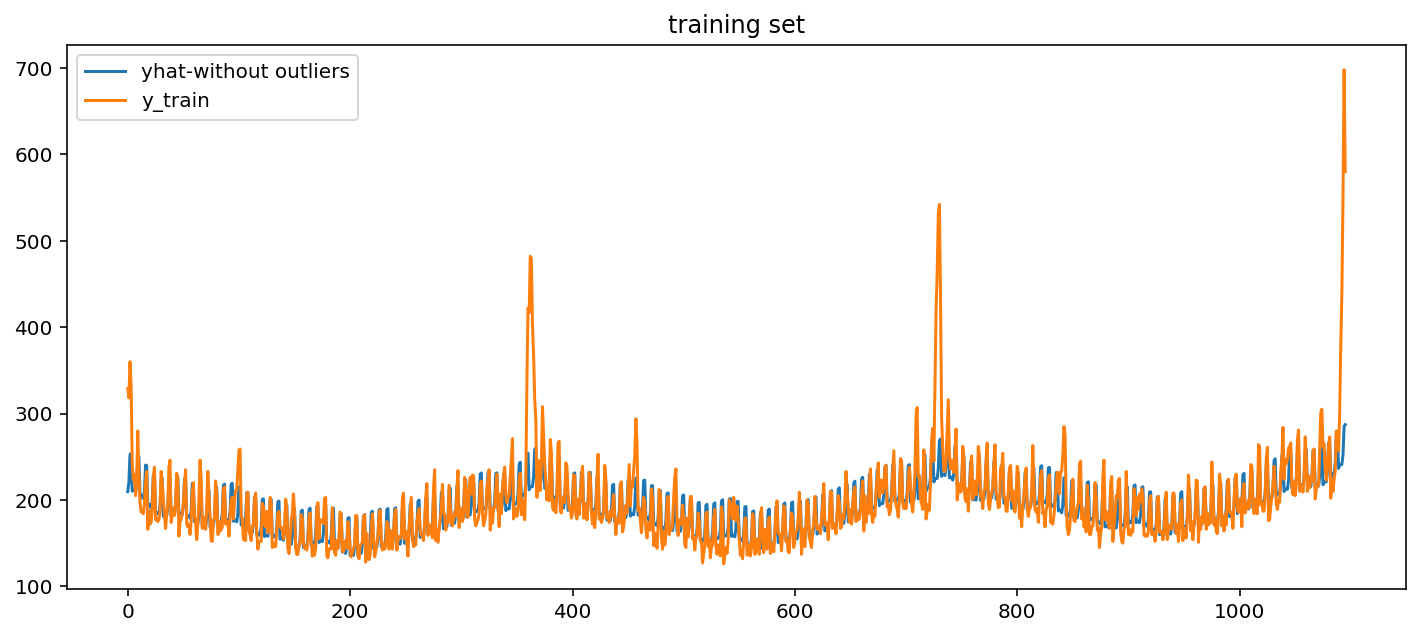

In [55]:
plt.figure(figsize=(12, 5))
ax=plt.plot(np.array(y_forecast_train))
plt.plot(np.array(y_train_original))
plt.title('training set')
plt.legend(['yhat-without outliers', 'y_train'])

# Hibrido

Train 2015-2017

Test 2018

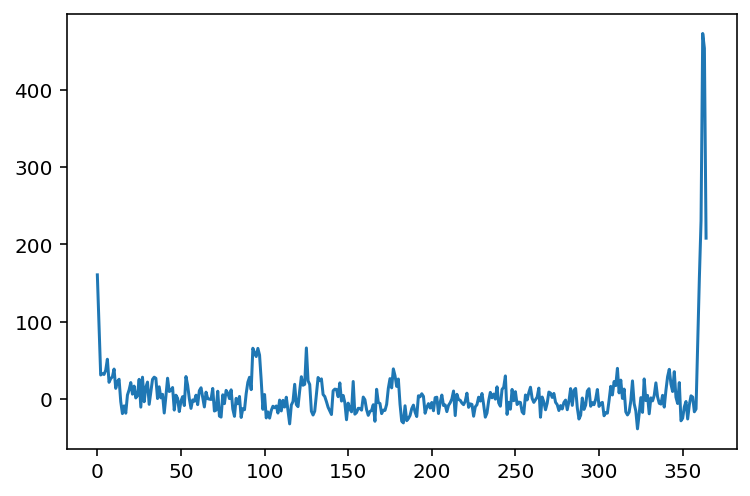

In [56]:
y_resid_predict=np.array(y_val_original)-np.array(y_forecast_future)
plt.plot(y_resid_predict)

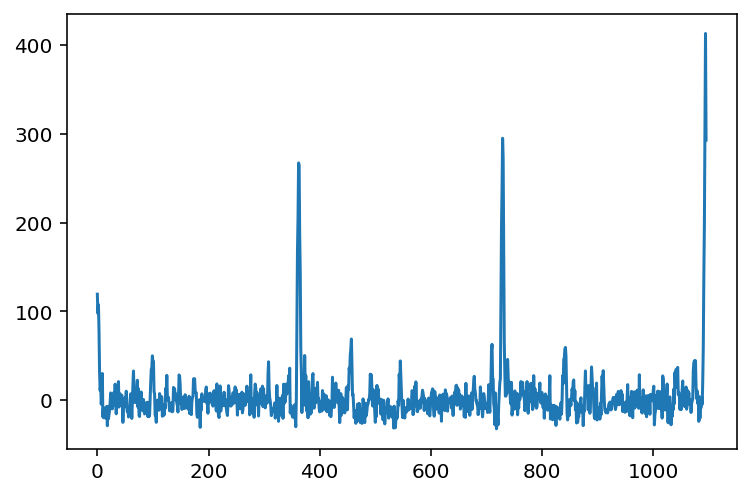

In [57]:
y_resid=np.array(y_train_original)-np.array(y_forecast_train)
plt.plot(y_resid)

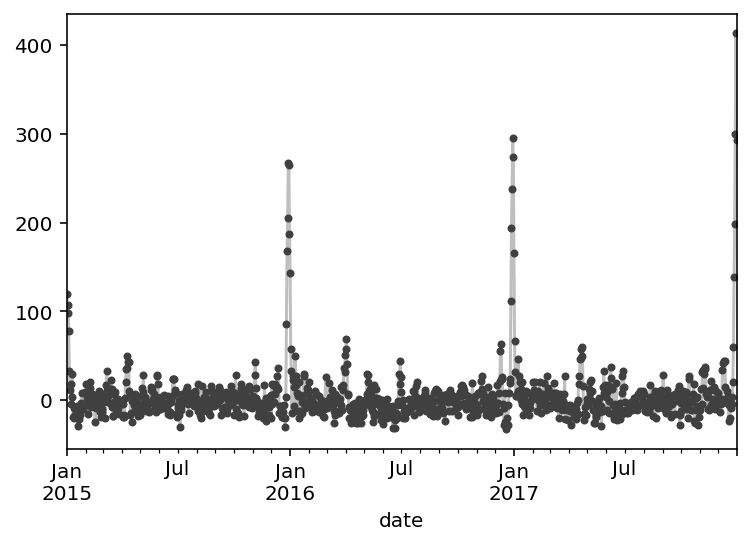

In [58]:
df_resid=pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_resid)],axis=1)
df_resid.rename({0: 'num_sold'}, axis=1, inplace=True)
df_resid = df_resid.set_index('date')
df_resid.plot(**plot_params)

In [59]:
X_new=sub_train[['day_year','day_month','month']]
X_2_train, X_2_test= train_test_split(X_new,shuffle=False,train_size=N-365,test_size=365)

In [60]:
X_2_train

,day_year,day_month,month
date,,,
2015-01-01,1,1,1
2015-01-02,2,2,1
2015-01-03,3,3,1
2015-01-04,4,4,1
2015-01-05,5,5,1
...,...,...,...
2017-12-27,361,27,12
2017-12-28,362,28,12
2017-12-29,363,29,12


In [61]:
y_hibrido=entrenar_hibrido(y_resid,X_2_train,X_2_test)
y_predict=y_forecast_future+y_hibrido

y_fit2 = pd.Series(y_hibrido, index=X_2_test.index)

[21:40:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


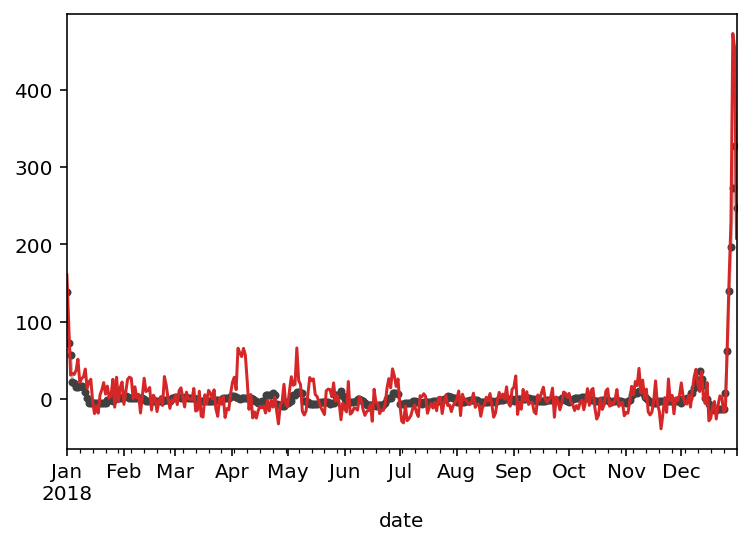

In [62]:
y_resid_predict_serie=pd.Series(y_resid_predict, index=X_2_test.index)
y_fit2.plot(** plot_params)
y_resid_predict_serie.plot(color='C3')

In [63]:
y_predict_total=pd.DataFrame(np.array(y_predict), index=X_2_test.index)
y_predict_total.rename({0: 'num_sold'}, axis=1, inplace=True)
y_predict_total

,num_sold
date,
2018-01-01,383.173661
2018-01-02,320.058822
2018-01-03,303.911639
2018-01-04,268.047524
2018-01-05,276.671987
...,...
2018-12-27,397.471393
2018-12-28,464.603306
2018-12-29,574.022600


18.50093444330284
7.0997038670304295


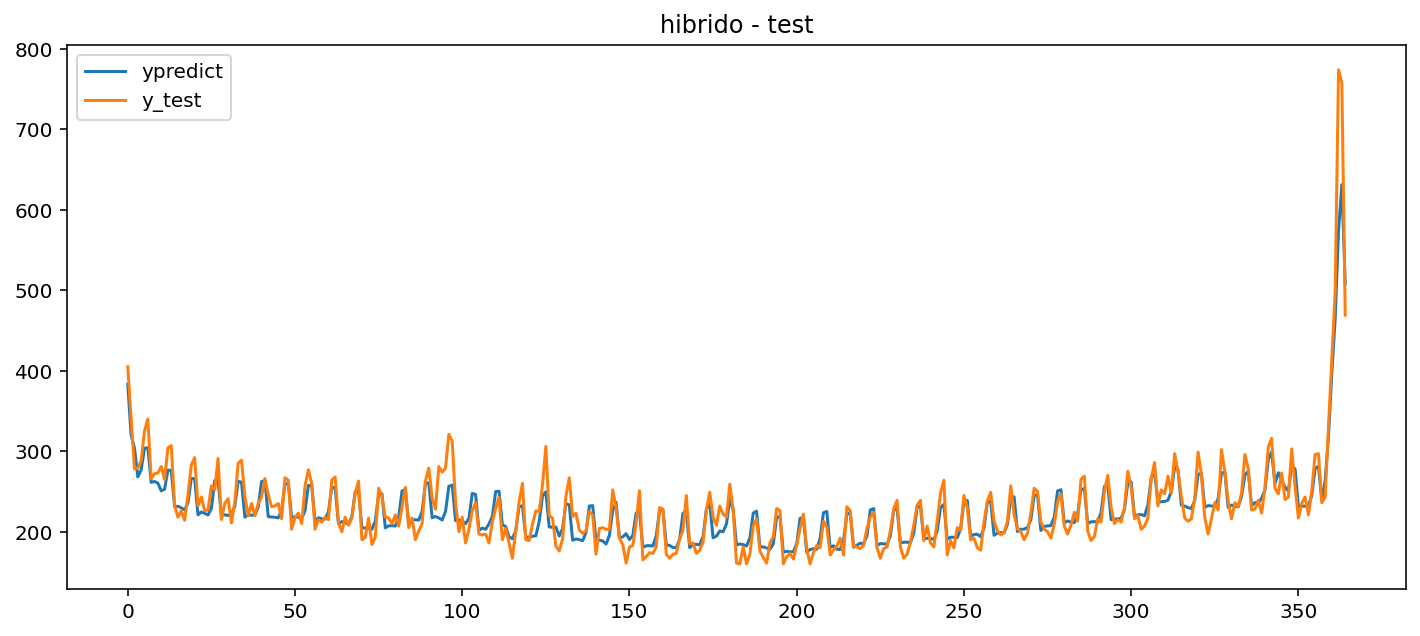

In [64]:
plt.figure(figsize=(12, 5))
ax=plt.plot(np.array(y_predict_total))
plt.plot(np.array(y_val_original))
plt.title('hibrido - test')
plt.legend(['ypredict', 'y_test'])

print(smape_loss(np.array(y_val_original), np.array(y_predict_total)).mean())

print(smape_loss(np.array(y_val_original), np.array(y_forecast_future)).mean())

# Holidays

Holidays from dataset

In [65]:
# Link con el Drive
#from google.colab import drive
#drive.mount('/content/drive')

#holiday_path = '/content/drive/MyDrive/kaggle_tabular_22/Holidays_Finland_Norway_Sweden_2015-2019.csv'
#holiday_df = pd.read_csv(holiday_path)#,parse_dates=['Date'])
#holidays_f=holiday_df[holiday_df['Country']=='Finland']
#holidays_f=holidays_f[holidays_f['Date']<'2019-01-01']
#holidays_f.rename({'Date': 'ds','Name':'holiday'}, axis=1, inplace=True)
#holidays_f['date'] = pd.to_datetime(holidays_f['ds'])
#holidays_f.head(14)

In [66]:
#holidays_finland =holidays_f[['ds','holiday']]

Using dataset with holidays in prophet

In [67]:
#model=prophet.Prophet(holidays=holidays_finland)
# fit the model
#model.add_seasonality(name='mensual',period=365/12,fourier_order=4)
#model.add_country_holidays
#model.fit(df)

#future = model.make_future_dataframe(periods=365)
#forecast = model.predict(future)
#model.plot(forecast);

#y_fore=forecast['yhat']
#y_fore_future=pd.DataFrame(y_fore[-365:])

In [68]:
#model.plot_components(forecast)

In [69]:
#model.params

# Prediccion kaggle

In [70]:
countrys = train['country'].unique()
stores = train['store'].unique()
products = train['product'].unique()

## initial - default prophet + holidays

In [71]:
df_predict = pd.DataFrame(columns = ['row_id', 'num_sold'])

#loop to iterate in every combination country/store/product
for i in countrys:
    for j in stores:
        for k in products:
            sub_train = train[(train['country'] == i) & (train['store'] == j) & (train['product'] == k)]
            sub_train = sub_train.set_index("date")
            df=pd.DataFrame(sub_train['num_sold'])  
            df=df.reset_index('date')
            df.rename({'date': 'ds','num_sold':'y'}, axis=1, inplace=True)
            sub_test = test[(test['country'] == i) & (test['store'] == j) & ((test['product'] == k))]
            df_test = sub_test.set_index('date')
            rows_ids=np.array(df_test['row_id'])
            y_predict,y_predict_train=entrenar_modelo(df,i,True)
            df_1=pd.DataFrame({'row_id': rows_ids, 'num_sold': y_predict})
            df_predict = pd.concat([df_predict,df_1],axis=0)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [72]:
df_predict.to_csv('modelo_1.csv',index=False)

## default prophet - No holidays

In [73]:
df_predict = pd.DataFrame(columns = ['row_id', 'num_sold'])

#loop to iterate in every combination country/store/product
for i in countrys:
    for j in stores:
        for k in products:
            sub_train = train[(train['country'] == i) & (train['store'] == j) & (train['product'] == k)]
            sub_train = sub_train.set_index("date")
            df=pd.DataFrame(sub_train['num_sold'])  
            df=df.reset_index('date')
            df.rename({'date': 'ds','num_sold':'y'}, axis=1, inplace=True)
            sub_test = test[(test['country'] == i) & (test['store'] == j) & ((test['product'] == k))]
            df_test = sub_test.set_index('date')
            rows_ids=np.array(df_test['row_id'])
            y_predict,y_predict_train=entrenar_modelo(df,i,False)
            df_1=pd.DataFrame({'row_id': rows_ids, 'num_sold': y_predict})
            df_predict = pd.concat([df_predict,df_1],axis=0)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


##  Removing outliers

No holidays

In [74]:
df_predict_wo = pd.DataFrame(columns = ['row_id', 'num_sold'])

#loop to iterate in every combination country/store/product
for i in countrys:
    for j in stores:
        for k in products:
            sub_train = train[(train['country'] == i) & (train['store'] == j) & (train['product'] == k)]
            sub_train['num_sold']=[ None if i >= np.percentile(sub_train['num_sold'], 95) or i <= np.percentile(sub_train['num_sold'] , 5) else i for i in sub_train['num_sold']  ]
            sub_train = sub_train.set_index("date")
            df=pd.DataFrame(sub_train['num_sold'])  
            df=df.reset_index('date')
            df.rename({'date': 'ds','num_sold':'y'}, axis=1, inplace=True)
            sub_test = test[(test['country'] == i) & (test['store'] == j) & ((test['product'] == k))]
            df_test = sub_test.set_index('date')
            rows_ids=np.array(df_test['row_id'])
            y_predict,y_predict_train=entrenar_modelo(df,i,False)
            df_1=pd.DataFrame({'row_id': rows_ids, 'num_sold': y_predict})
            df_predict_wo = pd.concat([df_predict_wo,df_1],axis=0)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [75]:
df_predict_wo.to_csv('modelo_2.csv',index=False)

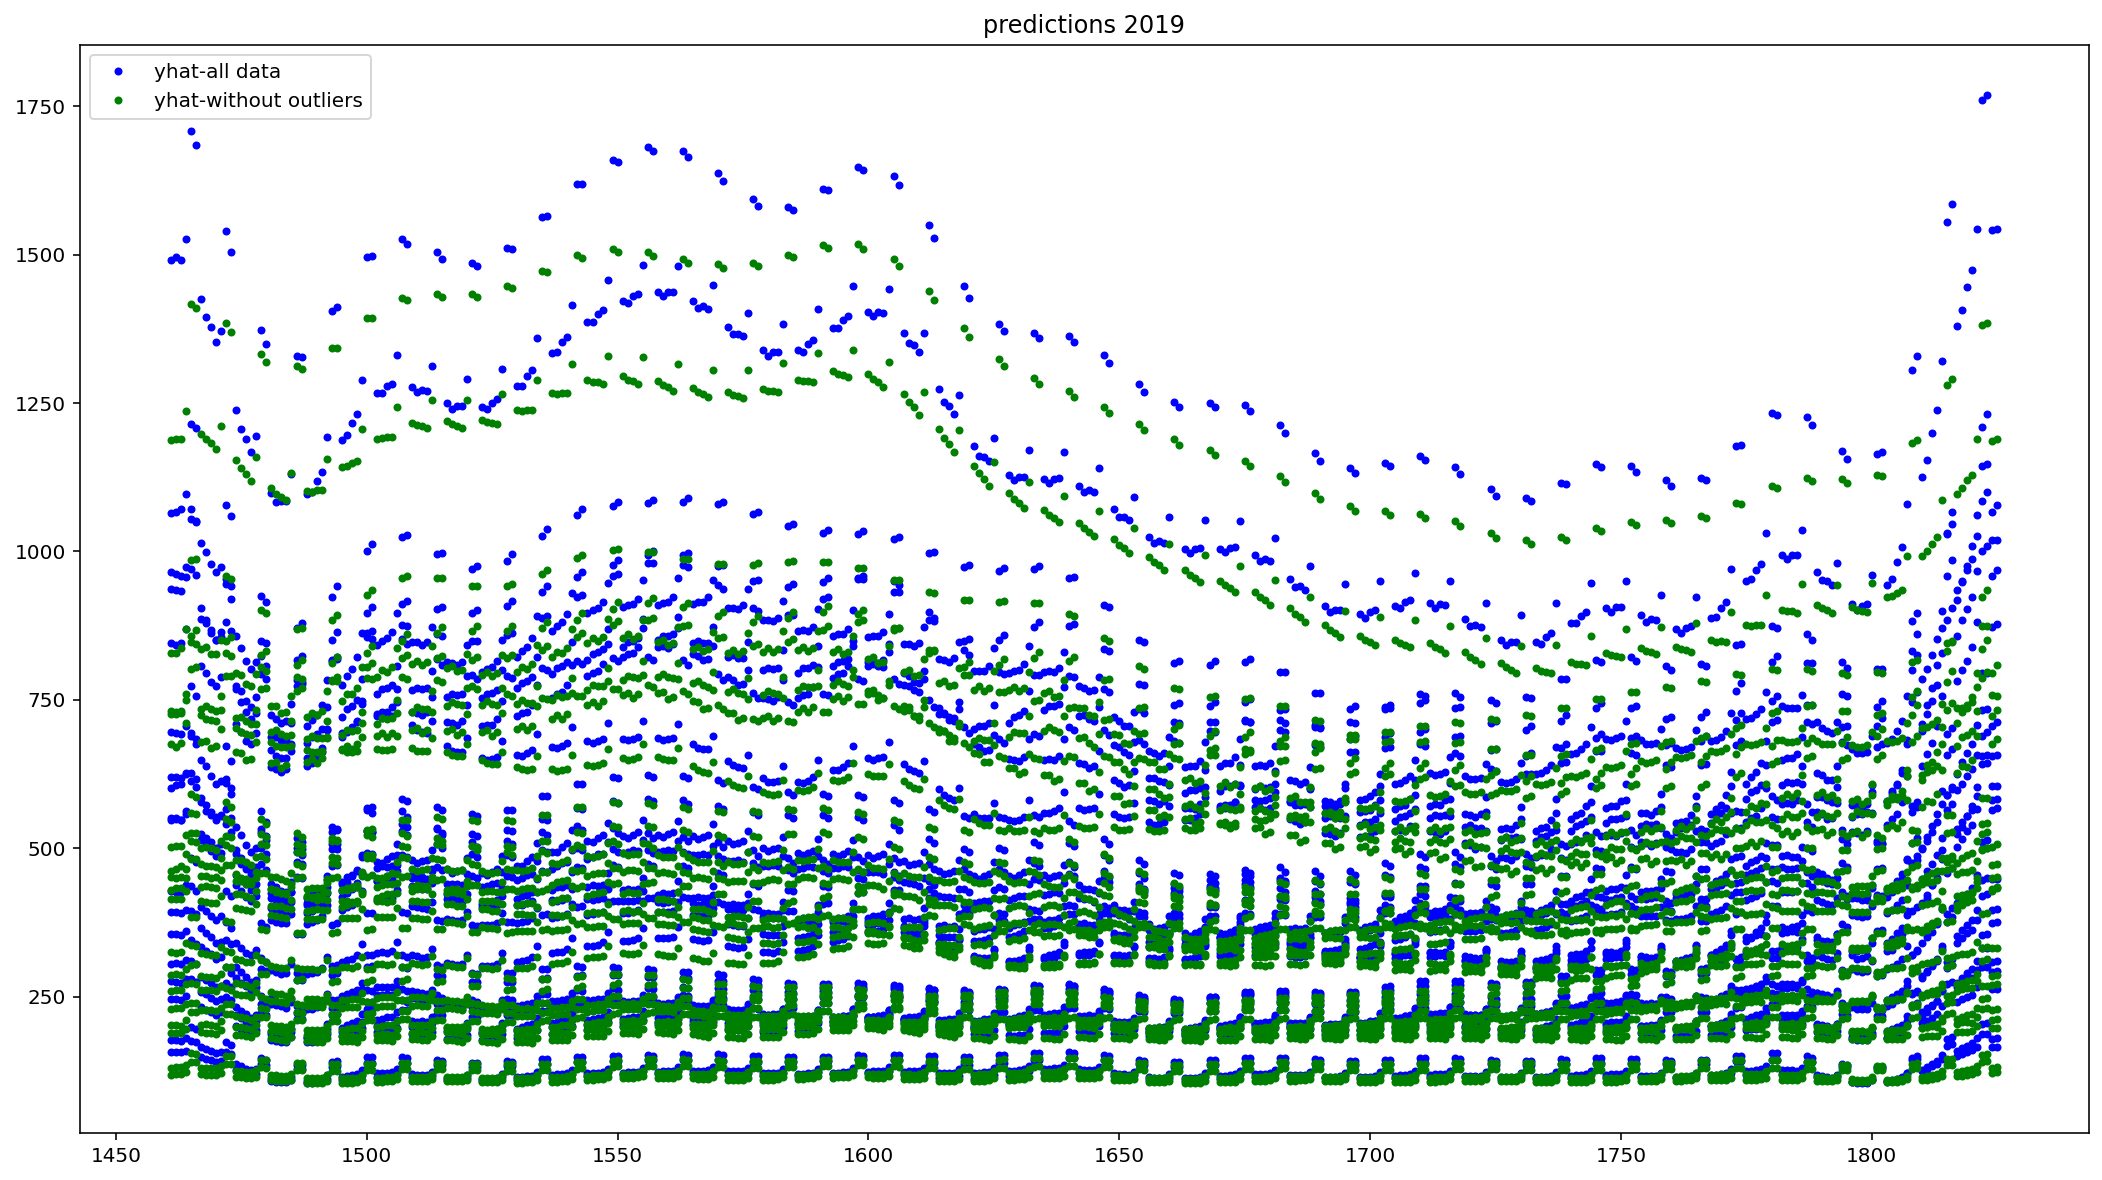

In [76]:
plt.figure(figsize=(18, 10))
plt.plot(df_predict['num_sold'],'b.')
plt.plot(df_predict_wo['num_sold'],'g.')
plt.title('predictions 2019')
plt.legend(['yhat-all data', 'yhat-without outliers'])

# Hybrid model

In [77]:
df_predict_h = pd.DataFrame(columns = ['row_id', 'num_sold'])

#loop to iterate in every combination country/store/product
for i in countrys:
    for j in stores:
        for k in products:
            sub_train = train[(train['country'] == i) & (train['store'] == j) & (train['product'] == k)]
            y_train_original=sub_train['num_sold']
            sub_train['num_sold']=[ None if i >= np.percentile(sub_train['num_sold'], 95) or i <= np.percentile(sub_train['num_sold'] , 5) else i for i in sub_train['num_sold']  ]
            sub_train = sub_train.set_index("date")
            df=pd.DataFrame(sub_train['num_sold'])  
            df=df.reset_index('date')
            df.rename({'date': 'ds','num_sold':'y'}, axis=1, inplace=True)
            sub_test = test[(test['country'] == i) & (test['store'] == j) & ((test['product'] == k))]
            df_test = sub_test.set_index('date')
            rows_ids=np.array(df_test['row_id'])

            y_predict,y_predict_train=entrenar_modelo(df,i,False)
            y_resid=np.array(y_train_original)-np.array(y_predict_train)
            X_2_train=sub_train[['day_year','day_month','month']]
            X_2_test=sub_test[['day_year','day_month','month']]
            
            y_hibrido=entrenar_hibrido(y_resid,X_2_train,X_2_test)
            y_predict=y_predict+y_hibrido
            df_1=pd.DataFrame({'row_id': rows_ids, 'num_sold': y_predict})
            df_predict_h = pd.concat([df_predict_h,df_1],axis=0)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:44:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


[21:45:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [78]:
df_predict_h.to_csv('modelo_3.csv',index=False)

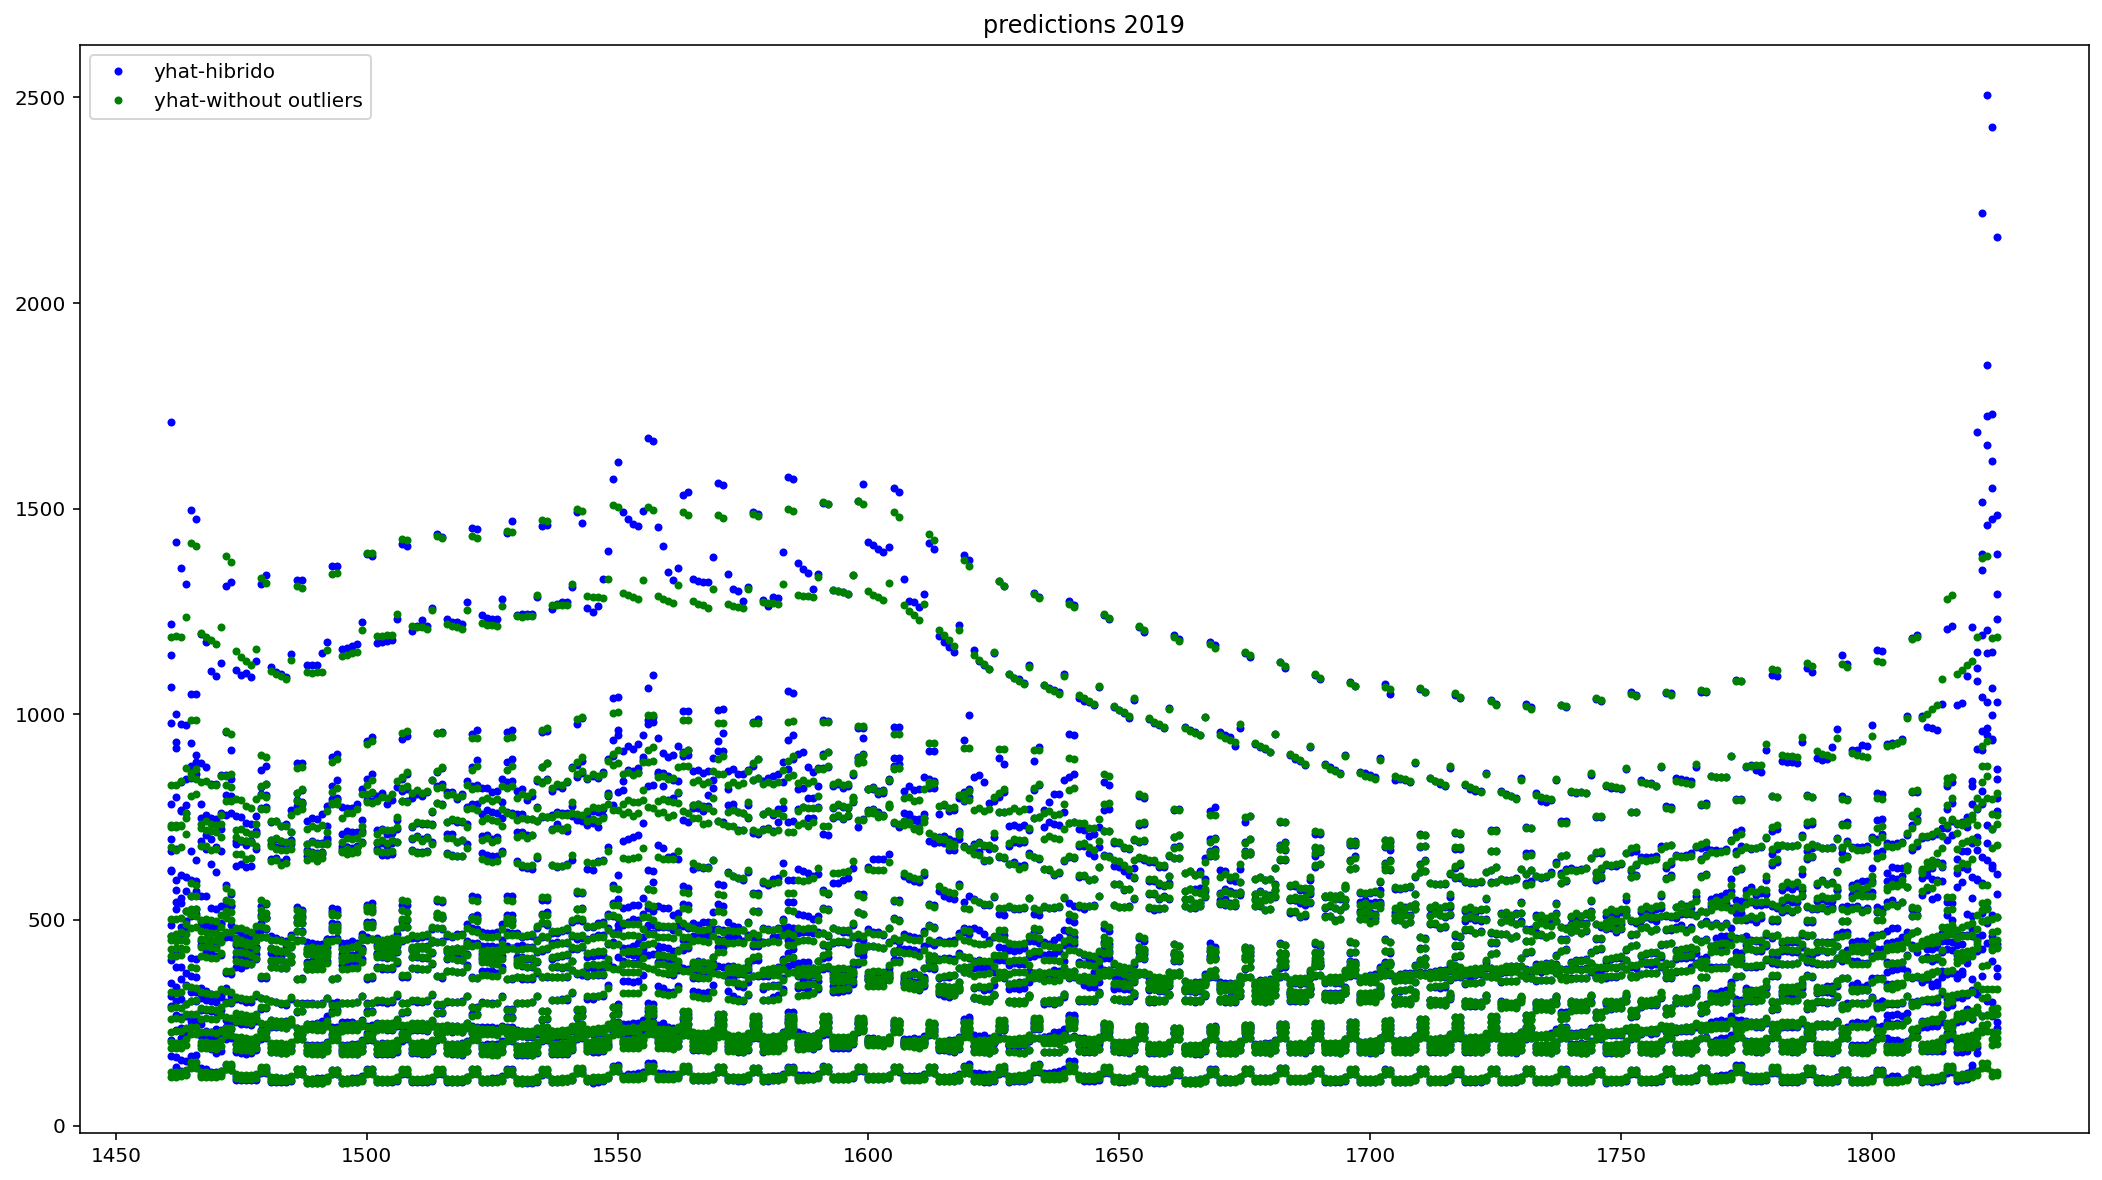

In [79]:
plt.figure(figsize=(18, 10))
plt.plot(df_predict_h['num_sold'],'b.')
plt.plot(df_predict_wo['num_sold'],'g.')
plt.title('predictions 2019')
plt.legend(['yhat-hibrido', 'yhat-without outliers'])